In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
fig_dir = 'figures/'
import sys
sys.path.append(module_path)
import time
import cv2
import datetime
import importlib
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from operator import itemgetter
from keras.models import load_model

%load_ext autoreload
%autoreload 1
%aimport distance_metrics
%aimport data_processing
%aimport plotting
# %aimport pso
%aimport pso_parallel_training_queue
from distance_metrics import minkowski_distance
from data_processing import *
from plotting import *
# from pso import *
from pso_parallel_training_queue import *

np.random.seed(999)
random.seed(999)

Using TensorFlow backend.


#### Set plot variables

In [182]:
### Standard plots
model_name = '6x6_tanh_xi10_loss_point9_cutoff_no_empty_bin_punish_nbin_weighted_loss'
mode_of_progress = 'validation' # 'training', 'validation'

data_type = 'val' # 'train', 'val, 'test'
iteration = '691'

plot_full_range = True

model = load_model('trained_networks/{}/{}_best/iter_{}.h5'.format(model_name, mode_of_progress, iteration))
training_data_dict = pickle.load(open('trained_networks/{}/{}_best/training_data_dict.p'.format(model_name, mode_of_progress), 'rb'))

predicted_points = predict_points(model, training_data_dict, mode=data_type, original_units=False)
title = 'Iteration {}, best {} weights, {} data points shown'.format(iteration, mode_of_progress, data_type)

#### Get reinforcement learning plots

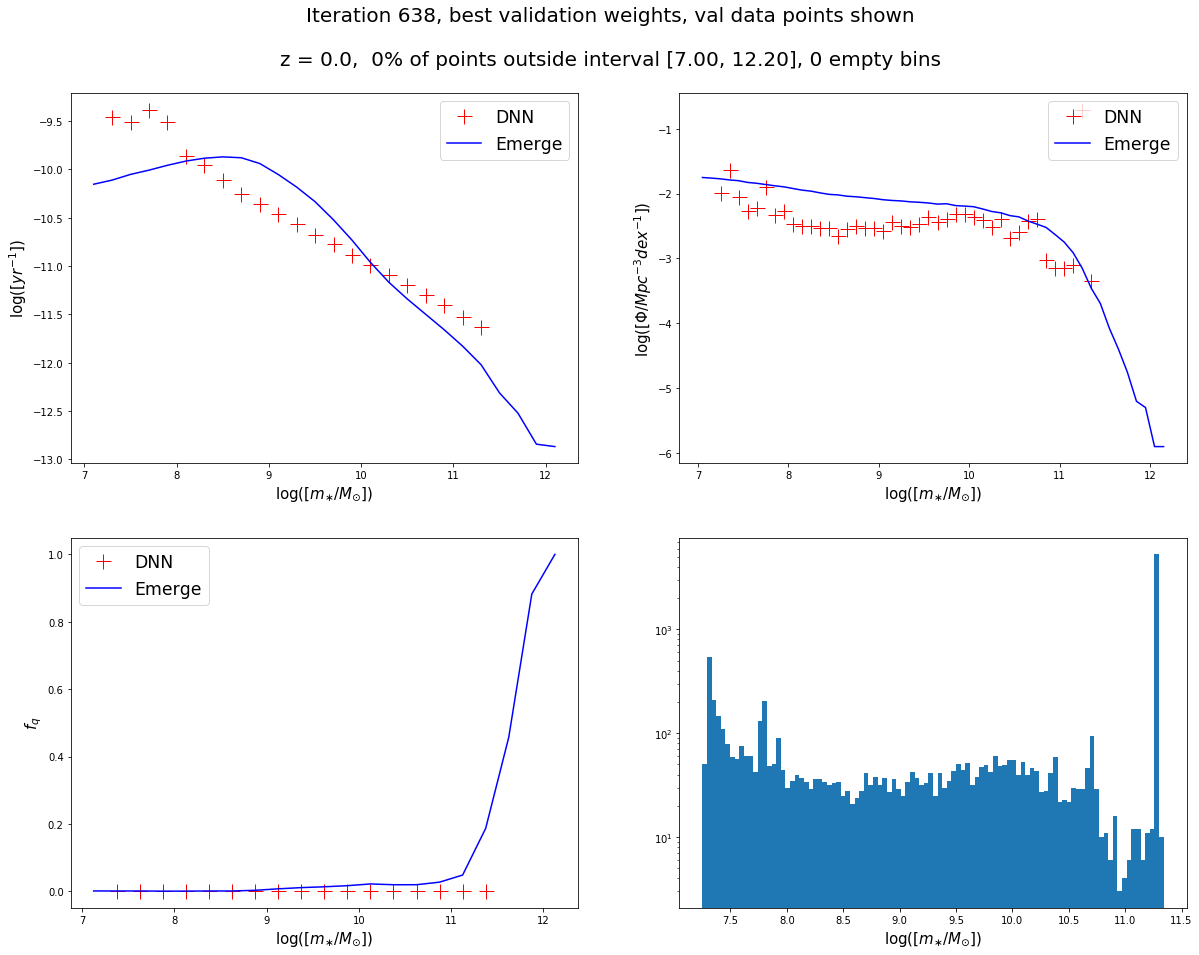

In [170]:
fig858 = get_smf_ssfr_fq_plot(model, training_data_dict, galaxies=None, title=title, data_type=data_type, full_range=True)

In [ ]:
fig73 = get_ssfr_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=data_type, full_range=plot_full_range)
fig55 = get_smf_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=data_type, full_range=plot_full_range)
fig33 = get_fq_plot(model, training_data_dict, unit_dict, galaxies=None, title=None, data_type=data_type, full_range=plot_full_range)

In [ ]:
fig73.savefig(fig_dir + 'ssfr_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')
fig55.savefig(fig_dir + 'smf_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')
fig33.savefig(fig_dir + 'fq_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')

#### Get standard pictures

In [ ]:
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'Stellar_mass', pso=True, title=title, data_type=mode,
                                   predicted_points = predicted_points, galaxies=galaxies)

fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)

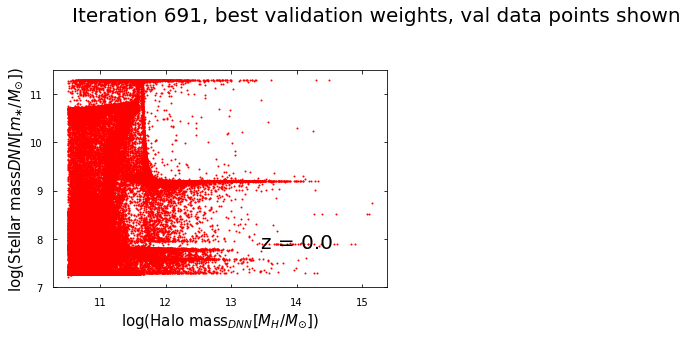

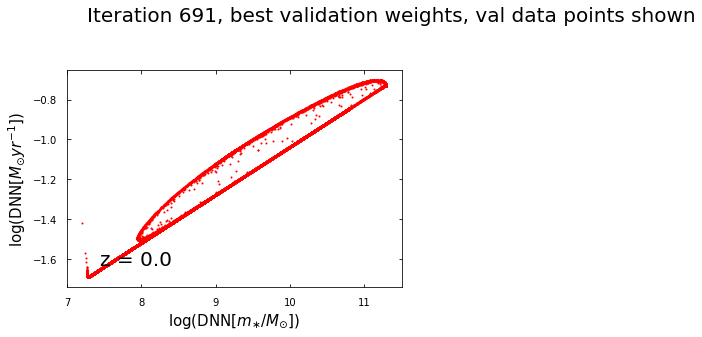

In [183]:
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, no_true_plots=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=data_type, predicted_points = predicted_points)

fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, no_true_plots=True, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=data_type, predicted_points = predicted_points)

In [ ]:
fig3.savefig(fig_dir + 'halo_stellar_mass_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + 'stellar_mass_sfr_plot_3_loss_func_4x4_400_iters_Z00.png', bbox_inches = 'tight')

In [ ]:
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, pso=True, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', pso=True, title=title, data_type=mode, marker_size=20, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
# fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
#                                  y_axis_feature = 'SFR', pso=True, title=title, data_type=mode, marker_size=20,
#                                  y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig6.savefig(fig_dir + 'proof_of_concept_3x3_net_one_output_no_weighing.png', bbox_inches = 'tight')

##### Create progress figures and movies

In [ ]:
model_name = 'lin_loss_func_slope_10_point9_cutoff_empty_bin_punish'

modes_of_progress = ['validation', 'training'] # 'training', 'validation'
data_types = ['val', 'train']

plot_types = ['smf', 'ssfr', 'fq']

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
frame_rate = 1

for mode_of_progress, data_type in zip(modes_of_progress, data_types):
    
    model_dir = 'trained_networks/{}/{}_best/'.format(model_name, mode_of_progress)
    model_fig_dir = 'trained_networks/{}/figures_{}_weights/{}_data/'.format(model_name, mode_of_progress, data_type)

    model_list = []
    for file in os.listdir(model_dir):
        if file == 'training_data_dict.p':
            training_data_dict_model = pickle.load(open(model_dir + file, 'rb'))
        else:
            nr = file[5:-3]
            model_list.append([file, int(nr)])

    model_list.sort(key=itemgetter(1))

    for model_file, iteration in model_list:
        model = load_model(model_dir + model_file)

        title = 'Iteration {}, best {} weights, {} data points shown'.format(iteration, mode_of_progress, data_type)
        if 'fq' in plot_types:
            fq_file_path = model_fig_dir + 'fq/' + 'iteration_{}.png'.format(iteration)
            get_fq_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=fq_file_path)
            
        if 'smf' in plot_types:
            smf_file_path = model_fig_dir + 'smf/' + 'iteration_{}.png'.format(iteration)
            get_smf_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=smf_file_path)
            
        if 'ssfr' in plot_types:
            ssfr_file_path = model_fig_dir + 'ssfr/' + 'iteration_{}.png'.format(iteration)
            get_ssfr_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=ssfr_file_path)
            
    for plot_type in plot_types:
        image_folder = 'trained_networks/{}/figures_{}_weights/{}_data/{}/'.format(model_name, weights, data_type, plot_type)
        video_path = image_folder + 'progress_video.avi'

        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        images_with_nrs = []
        for image in images:
            number = image.split('_')
            number = number[-1][:-4]
            images_with_nrs.append([image, int(number)])

        images_with_nrs.sort(key=itemgetter(1))

        images = [image_folder + items[0] for items in images_with_nrs]

        frame = cv2.imread(images[0])
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width,height))

        for image in images:
            img = cv2.imread(image)
            video.write(img)

        video.release()
        cv2.destroyAllWindows()
    

#### Movie with all three loss conditions in same fig

In [12]:
model_name = '6x6_tanh_xi10_loss_point9_cutoff_no_empty_bin_punish_nbin_weighted_loss'
modes_of_progress = ['validation'] # 'training', 'validation'
data_types = ['val'] # 'train', 'val'
produce_images = True

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
frame_rate = 1

for mode_of_progress, data_type in zip(modes_of_progress, data_types):
    if produce_images:
    
        model_dir = 'trained_networks/{}/{}_best/'.format(model_name, mode_of_progress)
        model_fig_dir = 'trained_networks/{}/figures_{}_weights/{}_data/all_losses/'.format(model_name, mode_of_progress, data_type)

        model_list = []
        for file in os.listdir(model_dir):
            if file == 'training_data_dict.p':
                training_data_dict_model = pickle.load(open(model_dir + file, 'rb'))
            else:
                nr = file[5:-3]
                model_list.append([file, int(nr)])

        model_list.sort(key=itemgetter(1))

        for model_file, iteration in model_list:
            model = load_model(model_dir + model_file)

            title = 'Iteration {}, best {} weights, {} data points shown'.format(iteration, mode_of_progress, data_type)
            fig_file_path = model_fig_dir + 'iteration_{}.png'.format(iteration)
            get_smf_ssfr_fq_plot(model, training_data_dict_model, galaxies=None, title=title, data_type=data_type, full_range=True, save=True, file_path=fig_file_path)

    image_folder = 'trained_networks/{}/figures_{}_weights/{}_data/all_losses/'.format(model_name, mode_of_progress, data_type)
    video_path = image_folder + 'progress_video5.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images_with_nrs = []
    for image in images:
        number = image.split('_')
        number = number[-1][:-4]
        images_with_nrs.append([image, int(number)])

    images_with_nrs.sort(key=itemgetter(1))

    images = [image_folder + items[0] for items in images_with_nrs]

    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width,height))

    for image in images:
        img = cv2.imread(image)
        video.write(img)

    video.release()
    cv2.destroyAllWindows()

1500 2000 3
1500 2000 3
1500 2000 3


<Figure size 432x288 with 0 Axes>

#### Distance between new high scores

dict_keys(['swarm_best_distance_moved_p_point_one', 'swarm_best_distance_moved_p_one', 'swarm_best_distance_moved_p_two', 'swarm_best_distance_moved_p_inf'])


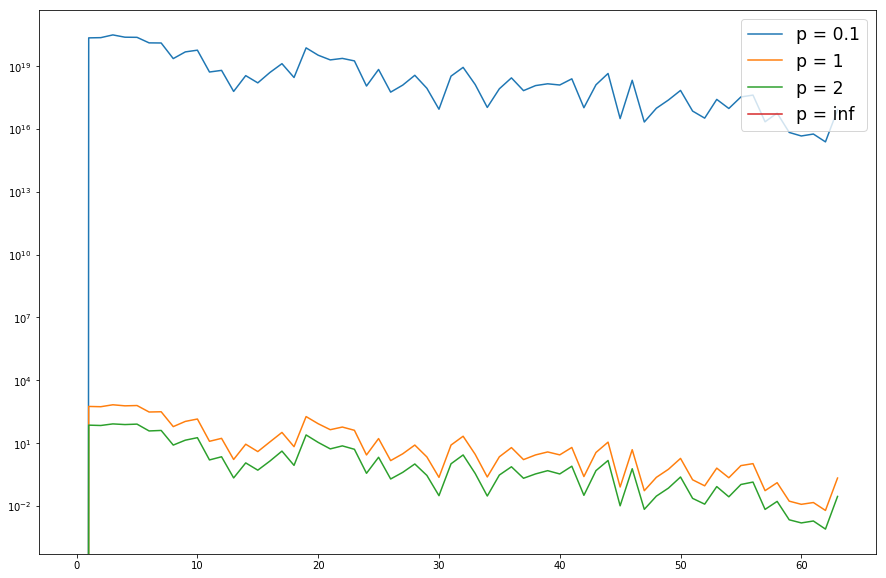

In [167]:
model_name = '4x4_relu_xi10_loss_point9_cutoff_no_empty_bin_punish'

model_dir = 'trained_networks/{}/'.format(model_name)
os.makedirs(os.path.dirname(model_dir + 'swarm_best_distance_moved.p'), exist_ok=True)
distance_dict = pickle.load(open(model_dir + 'swarm_best_distance_moved.p', 'rb'))

print(distance_dict.keys())

fig = plt.figure(figsize=(15,10))
plt.plot(distance_dict['swarm_best_distance_moved_p_point_one'])
plt.plot(distance_dict['swarm_best_distance_moved_p_one'])
plt.plot(distance_dict['swarm_best_distance_moved_p_two'])
plt.plot(distance_dict['swarm_best_distance_moved_p_inf'])
plt.legend(['p = 0.1', 'p = 1', 'p = 2', 'p = inf'], loc='upper right', fontsize='xx-large')
# plt.plot([dist[1][0] for dist in distance_dict['swarm_best_distance_moved_p_point_one']])
plt.yscale('log')

In [168]:
print(np.array(distance_dict['swarm_best_distance_moved_p_one'][10:])/np.array(distance_dict['swarm_best_distance_moved_p_point_one'][10:]))


[2.44914008e-18 2.33216956e-18 2.69463129e-18 2.67311774e-18
 2.52226793e-18 2.48257693e-18 2.29495025e-18 2.47739659e-18
 2.36178687e-18 2.48519875e-18 2.53843431e-18 2.20848219e-18
 2.50122001e-18 2.30550401e-18 2.42873315e-18 2.38319339e-18
 2.55013482e-18 2.49191973e-18 2.21596508e-18 2.49648566e-18
 2.64219040e-18 2.43152203e-18 2.44500721e-18 2.20108919e-18
 2.26357878e-18 2.68336625e-18 2.22581053e-18 2.41374527e-18
 2.32241696e-18 2.64452792e-18 2.18853152e-18 2.50796205e-18
 2.44830720e-18 2.78724575e-18 2.50266021e-18 2.56380307e-18
 2.30519757e-18 2.49071671e-18 2.38232658e-18 2.34016940e-18
 2.69708231e-18 2.48508394e-18 2.78658343e-18 2.48141573e-18
 2.33992120e-18 2.49961934e-18 2.53593594e-18 2.43902553e-18
 2.26432797e-18 2.48472945e-18 2.58836386e-18 2.54417065e-18
 2.52622469e-18 2.61653670e-18]


#### Interparticle distances

In [161]:
model_name = 'testing'

dict_dir = 'trained_networks/{}/interparticle_distances/'.format(model_name)
dict_list = []
for file in os.listdir(dict_dir):
    nr = file[5:-2]
    dict_list.append([file, int(nr)])

dict_list.sort(key=itemgetter(1))


p_point_one_list = []
p_one_list = []
p_two_list = []

for dict_file, iteration in dict_list:
    distance_dict = pickle.load(open(dict_dir + dict_file, 'rb'))
    
    p_point_one = []
    p_one = []
    p_two = []
    
    for i in range(np.shape(distance_dict['p_point_one'])[0]):
        for j in range(i+1, np.shape(distance_dict['p_point_one'])[1]):
            p_point_one.append(distance_dict['p_point_one'][i,j])
    for i in range(np.shape(distance_dict['p_one'])[0]):
        for j in range(i+1, np.shape(distance_dict['p_one'])[1]):
            p_one.append(distance_dict['p_one'][i,j])
    for i in range(np.shape(distance_dict['p_two'])[0]):
        for j in range(i+1, np.shape(distance_dict['p_two'])[1]):
            p_two.append(distance_dict['p_two'][i,j])
            
    p_point_one_list.append(p_point_one)
    p_one_list.append(p_one)
    p_two_list.append(p_two)
    

for interpart_dist_dict in dict_list:
    
    print(interpart_dist_dict)
    
    

['iter_0.p', 0]
['iter_1.p', 1]
['iter_2.p', 2]
['iter_3.p', 3]
['iter_4.p', 4]
['iter_5.p', 5]
['iter_6.p', 6]
['iter_7.p', 7]
['iter_8.p', 8]
['iter_9.p', 9]
['iter_10.p', 10]
['iter_11.p', 11]
['iter_12.p', 12]
['iter_13.p', 13]
['iter_14.p', 14]
['iter_15.p', 15]
['iter_16.p', 16]
['iter_17.p', 17]
['iter_18.p', 18]
['iter_19.p', 19]
['iter_20.p', 20]
['iter_21.p', 21]
['iter_22.p', 22]
['iter_23.p', 23]
['iter_24.p', 24]
['iter_25.p', 25]
['iter_26.p', 26]
['iter_27.p', 27]
['iter_28.p', 28]
['iter_29.p', 29]
['iter_30.p', 30]
['iter_31.p', 31]
['iter_32.p', 32]
['iter_33.p', 33]
['iter_34.p', 34]
['iter_35.p', 35]
['iter_36.p', 36]
['iter_37.p', 37]
['iter_38.p', 38]
['iter_39.p', 39]
['iter_40.p', 40]
['iter_41.p', 41]
['iter_42.p', 42]
['iter_43.p', 43]
['iter_44.p', 44]
['iter_45.p', 45]
['iter_46.p', 46]
['iter_47.p', 47]
['iter_48.p', 48]
['iter_49.p', 49]
['iter_50.p', 50]
['iter_51.p', 51]
['iter_52.p', 52]
['iter_53.p', 53]
['iter_54.p', 54]
['iter_55.p', 55]
['iter_56.p'

In [159]:
os.makedirs(os.path.dirname(model_dir + 'interparticle_distances/iter_{}.p'), exist_ok=True)
distance_dict = pickle.load(open(model_dir + 'interparticle_distances.p', 'rb'))


print(distance_dict.keys())
print(distance_dict['p_point_one'])

fig = plt.figure(figsize=(15,10))
plt.plot(distance_dict['p_point_one'], 'bo')
plt.plot(distance_dict['p_one'], 'rx')
plt.plot(distance_dict['p_two'], 'g.')
plt.legend(['p = 0.1', 'p = 1', 'p = 2'], loc='upper right', fontsize='xx-large')
# plt.plot([dist[1][0] for dist in distance_dict['swarm_best_distance_moved_p_point_one']])
plt.yscale('log')

FileNotFoundError: [Errno 2] No such file or directory: 'trained_networks/testing/interparticle_distances.p'

In [135]:
a = [[1,2],[3,4],[10,2]]
b = minkowski_distance(a, p=20)
print(b)

invalid i=0, j=2
[9 0]
[81  0]
8.10e+01
1.25e+00
[[0.         2.07052985 0.        ]
 [2.07052985 0.         7.        ]
 [0.         7.         0.        ]]


In [128]:
np.power(0, 9)

0

### Non parallel PSO

In [ ]:
mode = 'train'
network.pso_swarm.set_best_weights('train')
norm_score = network.pso_swarm.evaluate_model(mode)
tot_score = norm_score
model = network.model
title = 'Inputs: %s\ntest mse %.3e, %s data' % (', '.join(input_features), tot_score, mode)

fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, mode=mode)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, mode=mode)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, mode=mode)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, mode=mode)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 10, y_min = None,
                                    x_min = None, x_max = None, mode=mode)

plt.show

#### Train new network

In [ ]:
### General parameters
total_set_size = 2.9e4 # how many examples will be used for training+validation+testing
train_size = 2e4
val_size = .5e4
test_size = .4e4
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']#, 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0]#,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False # if using the smf in the objective function, must be false!
outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

reinforcement_learning = True
real_observations = False

verbatim = True

network_name = 'testing2'
# network_name = '{}'.format(datetime.datetime.now().strftime("%Y-%m-%d"))
save_all_nets = True

### Network parameters
nr_hidden_layers = 4
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
nr_neurons_per_layer = 4
regularisation_strength = 1e-2
std_penalty = False
norm = {'input': 'zero_mean_unit_std',
        'output': 'zero_mean_unit_std'} # 'none',   'zero_mean_unit_std',   'zero_to_one'

### PSO parameters
nr_processes = 30
nr_iterations = 1000
min_std_tol = 0.01                # minimum allowed std for any parameter
pso_param_dict = {
    'nr_particles': 3 * nr_processes,
    'inertia_weight_start': 1.4,
    'inertia_weight_min': 0.3,
    'exploration_iters': 600,
    'patience': 10000,
    'patience_parameter': 'train',
    'restart_check_interval': 200
}

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Load and preprocess the data

In [ ]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts, weigh_by_redshift, outputs_to_weigh,
                                       int(total_set_size), train_size=int(train_size), val_size=int(val_size), test_size=int(test_size), pso=True)
training_data_dict = normalise_data(training_data_dict, norm, pso=True)

# Create a new network

In [ ]:
network = Feed_Forward_Neural_Network(nr_hidden_layers, nr_neurons_per_layer, input_features, output_features, 
                                      activation_function, output_activation, regularisation_strength, network_name)
network.setup_pso(pso_param_dict, reinf_learning=reinforcement_learning, real_observations=real_observations, nr_processes=nr_processes)
network.train_pso(nr_iterations, training_data_dict, std_penalty=std_penalty, verbatim=verbatim, save_all_networks=save_all_nets)